# Coursera  Assignment


### Import the libraries used for the asignment

In [ ]:
#Import libraries
!pip install beautifulsoup4
!pip install bs4
from urllib.request import urlopen

from bs4 import BeautifulSoup
import datetime
import re
import numpy as np
import pandas as pd
import csv

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

# import k-means from clustering stage
from sklearn.cluster import KMeans

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Get Toronto Postal Code information from Wikipedia

### 1.1 HTML Formatting Functions 

In [3]:
def remove_tags(data_arr_list):
    tags = ["<td>", "</td>", "\n", "td>" , "</td", "]]"]
    for i in range(0, len(data_arr_list)):
        for j in range(0, len(tags)):
            if str(tags[j]) in str(data_arr_list[i]):
                data_arr_list[i] = data_arr_list[i].replace(tags[j], "")
                if 'title="' in str(data_arr_list[i]):
                    data_arr_list[i] = str(data_arr_list[i]).split('title="')[1].split('">')[0]
    
    return (data_arr_list)

In [4]:
def compile_postal(data_arr_list):

    #Compare the postal code to the next one in order
    for i in range (0, len(data_arr_list)-3, 3):

        if str(data_arr_list[i]) == str(data_arr_list[i+3]):
            #Add to the current postal code
            if str(data_arr_list[i+4]) not in data_arr_list[i+1]:
                data_arr_list[i+1] = str(data_arr_list[i+1]) + ", " + str(data_arr_list[i+4])
            if str(data_arr_list[i+5]) not in data_arr_list[i+2]:
                data_arr_list[i+2] = str(data_arr_list[i+2]) + ", " + str(data_arr_list[i+5])
            
            #Remove old entry(s)
            del(data_arr_list[i+3])
            del(data_arr_list[i+3])
            del(data_arr_list[i+3])
            
            data_arr_list = compile_postal(data_arr_list)
            
            break
            
    return data_arr_list

In [5]:
# Description: Drop borough rows that are N/A

def drop_na_borough(data_arr_list):

    for i in range (1, len(data_arr_list)-1, 3):
        if str(data_arr_list[i]) == 'Not assigned':
            
            #Remove the row
            del(data_arr_list[i-1])
            del(data_arr_list[i-1])
            del(data_arr_list[i-1])
            
            data_arr_list = drop_na_borough(data_arr_list)
            break
            
    return data_arr_list

In [6]:
def neighborhood_borough(data_arr_list):
    
    for i in range (2, len(data_arr_list), 3):
        if str(data_arr_list[i]) == 'Not assigned':
            
            data_arr_list[i] = str(data_arr_list[i-1])
            data_arr_list = neighborhood_borough(data_arr_list)
            
            break
            
    return data_arr_list

### 1.2 Identify Postal Code Information from the Wikipedia page

In [7]:
# specify the url
quote_page = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"

# query the website and return the html to the variable ‘page’
page = urlopen(quote_page)

# parse the html using beautiful soup and store in variable `soup`
soup = BeautifulSoup(page, "html.parser")

#Define array to hold all of the data points
data_arr = []

#Get the first table in the html
data = soup.findAll('table')

#assign the cells to the array
for row in data:
    for item in row.findAll('td'):
        if "<td>" in str(item):
            data_arr.append(str(item))

#Remove the last element in the list as it is invalid
data_arr.pop()            

#Clean up the tags and data points

#Remove HTML tags
data_arr = remove_tags(data_arr)

#Compile postal codes
data_arr = compile_postal(data_arr)

#Drop Not assigned boroughs
data_arr = drop_na_borough(data_arr)

#Assign borough to n/a neighborhoods
data_arr = neighborhood_borough(data_arr)

## 2. Create a Pandas Dataframe with Toronto data

### 2.1 Display the Dataframe with Wikipedia Information

In [8]:
#Create a dictionary
toronto_dict = {'Postal_Code':data_arr[0::3], 'Borough': data_arr[1::3], 
                                     'Neighborhood':data_arr[2::3] }

#Pandas Data frame
toronto_df = pd.DataFrame.from_dict(toronto_dict)

#*********Uncomment these lines to focus only on those boroughs in Toronto - containing the word Toronto*********#
#toronto_df = toronto_df[toronto_df['Borough'].str.contains("Toronto")==True]
#toronto_df.reset_index(drop=True, inplace=True)

#Print the shape of the new frame and display the first 5 rows
print(toronto_df.shape)

toronto_df.head()

(103, 3)


,Postal_Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Queen's Park (Toronto),Queen's Park (Toronto)


### 2.2 Add location information to the Dataframe

In [10]:
#Add the Latitude and Longitude columns to the table and initialize with placeholder information
toronto_df['Latitude'] = 'Not Set'
toronto_df['Longitude'] = 'Not Set'

#Open file containing the geospacial coordinates for Toronto
with open('Geospatial_Coordinates.csv', 'r') as csvfile:
    geo_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in geo_reader:
        #Find the postal code in the fame and add coordinates
        toronto_df.loc[toronto_df['Postal_Code'] == str(row[0]), "Latitude"] = str(row[1])
        toronto_df.loc[toronto_df['Postal_Code'] == str(row[0]), "Longitude"] = str(row[2])
        
#Set type to numeric
toronto_df['Latitude'] = pd.to_numeric(toronto_df['Latitude'])
toronto_df['Longitude'] = pd.to_numeric(toronto_df['Longitude'])


toronto_df.head()

,Postal_Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park (Toronto),Queen's Park (Toronto),43.662301,-79.389494


### 2.3 Add population information to the Dataframe

In [12]:
#Add the population columns to the table and initialize with placeholder information
toronto_df['Population'] = 'Not Set'

#Open file containing the geospacial coordinates for Toronto
with open('Canada Population.csv', 'r') as csvfile:
    geo_reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in geo_reader:
        #Find the postal code in the fame and add coordinates
        toronto_df.loc[toronto_df['Postal_Code'] == str(row[0]), "Population"] = str(row[4])

#For those without population data, remove them, from the dataframe
toronto_df = toronto_df[toronto_df['Population'].str.contains("Not Set")==False]
toronto_df.reset_index(drop=True, inplace=True)
toronto_df['Population'] = pd.to_numeric(toronto_df['Population'])

toronto_df.head()

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615
1,M4A,North York,Victoria Village,43.725882,-79.315572,14443
2,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636,41078
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,21048
4,M7A,Queen's Park (Toronto),Queen's Park (Toronto),43.662301,-79.389494,10


### 2.4 Remove underpopulated postal codes from the dataframe

In [13]:
#Remove rows with < 25000 population
clip = 20000

toronto_df = toronto_df[toronto_df['Population'].ge(25000)]
toronto_df ['Population'] = pd.to_numeric(toronto_df ['Population'])
toronto_df.reset_index(drop=True, inplace=True)

toronto_df.head()

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615
1,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636,41078
2,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,35594
3,M1B,"Scarborough, Toronto","Rouge, Toronto, Malvern, Toronto",43.806686,-79.194353,66108
4,M6B,North York,Glencairn,43.709577,-79.445073,28522


# 3. Get nearby venues from Foursquare

### 3.1 Foursquare credentials

In [15]:
CLIENT_ID = 'B0K442ZABARQK0HVKEPBPEPLSDNBXTGUQ2PEOEU0AMDN4YAJ' # your Foursquare ID
CLIENT_SECRET = 'TOTW50KQOA02KK343155NVTYIGO4XW3PP2SDNYZEBZYV4Z3D' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

### 3.2 Foursquare function to pull nearby values

In [16]:
## Cognitive Class.ai
## Segmenting and Clustering Neighborhoods in New York City
## Note: This function is taken from : https://labs.cognitiveclass.ai/tools/jupyterlab/lab/tree/labs/DP0701EN/DP0701EN-3-3-2-Neighborhoods-New-York-py-v1.0.ipynb
## I do not take credit for writing the below function
## I have used this function and made changes where nessesary for use in this project

#This function will get the near-by venues of a location using coordinates

def getNearbyVenues(names, latitudes, longitudes, radius):
    
    venues_list=[]
    remove = []
    for name, lat, lng in zip(names, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        #Log postal codees without nearby addresses 
        if not results:
            remove.append(name)

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal_Code', 
                  'Postal_Latitude', 
                  'Postal_Longitude', 
                  'Venue', 
                  'Venue_Latitude', 
                  'Venue_Longitude', 
                  'Venue_Category']
    
    return(nearby_venues, remove)

### 3.3 Get venues and add to the Dataframe

In [17]:
#Radius of 750m and a limit of 100 venues
radius = 750
LIMIT = 100


#Get the venues near Toronto postal codes
toronto_venues,remove = getNearbyVenues(names=toronto_df['Postal_Code'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'],
                                   radius = radius
                                  )

#Remove those postal codes with no nearby venues
for item in remove:
    indexNames = toronto_df[ toronto_df['Postal_Code'] == item ].index
    # Delete these row indexes from dataFrame
    toronto_df.drop(indexNames , inplace=True)

### 3.4 Examine the dataframe

In [18]:
# Display the shape of the dataframe and the first 5 rows
toronto_venues.head(5)

,Postal_Code,Postal_Latitude,Postal_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,M3A,43.753259,-79.329656,DVP at York Mills,43.758899,-79.334099,Road
3,M3A,43.753259,-79.329656,TTC Stop #09083,43.759655,-79.332223,Bus Stop
4,M5A,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery


In [19]:
#Determine how many unique categories there are 
print('There are {} uniques categories.'.format(len(toronto_venues['Venue_Category'].unique())))

There are 247 uniques categories.


In [20]:
#Display the categories:
for i in range (0, len(toronto_venues['Venue_Category'].unique())):
    print(toronto_venues['Venue_Category'].unique()[i])

Park
Food & Drink Shop
Road
Bus Stop
Bakery
Coffee Shop
Gym / Fitness Center
Restaurant
Spa
Historic Site
Farmers Market
Chocolate Shop
Breakfast Spot
Dessert Shop
Pub
Performing Arts Venue
Mediterranean Restaurant
French Restaurant
Café
Italian Restaurant
Mexican Restaurant
Liquor Store
Tech Startup
Shoe Store
Theater
Yoga Studio
Thai Restaurant
Ice Cream Shop
Event Space
Spanish Restaurant
Animal Shelter
Art Gallery
Brewery
Cosmetics Shop
Furniture / Home Store
Pool
Gastropub
Sandwich Place
Electronics Store
Pet Store
Food Truck
Bar
Beer Store
Bank
Skating Rink
Pharmacy
Discount Store
Fast Food Restaurant
Grocery Store
Hotel
Health Food Store
Antique Shop
Health & Beauty Service
Tram Station
Athletics & Sports
Dance Studio
Shopping Mall
Playground
Paper / Office Supplies Store
Hobby Shop
Construction & Landscaping
Filipino Restaurant
Japanese Restaurant
Latin American Restaurant
Pizza Place
Metro Station
Tennis Court
American Restaurant
Gym
Convenience Store
Burger Joint
History Muse

# 4. Assign points to the venues

### 4.1 Define function to determine point value for venues

In [21]:
def get_points(venue):
    venue = venue.lower() 
    venue = venue.split()
    value = 1
    
    two_points = ["bar", "pub", "bus", "transport", "rail", "plane" \
                        , "boat", "airport", "ferry", "station"]
    three_points = ["church", "club", "hotel", "hostel", "community", \
                        "museaum", "court", "field", "stadium", "sport", \
                        "playground", "theatre", "gallery", "center", "hall", \
                        "event", "park"]
    four_points = ["store", "shop", "mall", "plaza", "market", "grocery"]
    five_points = ["office", "school"]
    minus_two = ["restaurant", "joint", "diner", "food"]
    minus_ten = ["adult"]
    
    for word in venue:
        if word in two_points:
            if 2 > value:
                value = 2

        if word in three_points:
            if 3 > value:
                value = 3

        if word in four_points:
            if 4 > value:
                value = 4

        if word in five_points:
            if 5 > value:
                value = 5

        if word in minus_two:
            if value > -2:
                value = -2  

        if word in minus_ten:
            if value > -10:    
                value = -10
    
    return (value)

### 4.2 Add column to dataframe to record points

In [22]:
#Add the points column to the df
toronto_venues['Point_Value'] = "Not Set"

#Get the point value for each venue
for i in range(0, len(toronto_venues)):
    toronto_venues["Point_Value"][i] = get_points(str(toronto_venues["Venue_Category"][i]))
    

toronto_venues['Point_Value'] = pd.to_numeric(toronto_venues['Point_Value'])

toronto_venues.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Postal_Code,Postal_Latitude,Postal_Longitude,Venue,Venue_Latitude,Venue_Longitude,Venue_Category,Point_Value
0,M3A,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park,3
1,M3A,43.753259,-79.329656,Variety Store,43.751974,-79.333114,Food & Drink Shop,4
2,M3A,43.753259,-79.329656,DVP at York Mills,43.758899,-79.334099,Road,1
3,M3A,43.753259,-79.329656,TTC Stop #09083,43.759655,-79.332223,Bus Stop,2
4,M5A,43.654260,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery,1


### 4.3 Add sum of venue points to the postal code in toronto_df

In [23]:
#Add the points column to the toronto_df
toronto_df['Point_Value'] = "Not Set"

#Sum the venues points for each postal code and add to toronto_df
for i in range(0, len(toronto_df)):
    toronto_df["Point_Value"][i] = toronto_venues[ toronto_venues['Postal_Code'] \
                                           == toronto_df["Postal_Code"][i]]["Point_Value"].sum() 

toronto_df['Point_Value'] = pd.to_numeric(toronto_df['Point_Value'])

toronto_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population,Point_Value
0,M3A,North York,Parkwoods,43.753259,-79.329656,34615,10
1,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636,41078,140
2,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,35594,19
3,M1B,"Scarborough, Toronto","Rouge, Toronto, Malvern, Toronto",43.806686,-79.194353,66108,13
4,M6B,North York,Glencairn,43.709577,-79.445073,28522,11


### 4.4 Sort the df and analyze the results

In [24]:
#Sort the df in descending order
toronto_df = toronto_df.sort_values(by='Point_Value', ascending=False)

#display the df
toronto_df.head(5)

,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population,Point_Value
1,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636,41078,140
24,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,40957,98
23,M4K,East Toronto,"The Danforth West, Riverdale, Toronto",43.679557,-79.352188,31583,86
35,M6P,West Toronto,"High Park, The Junction South",43.661608,-79.464763,40035,84
18,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,58293,83


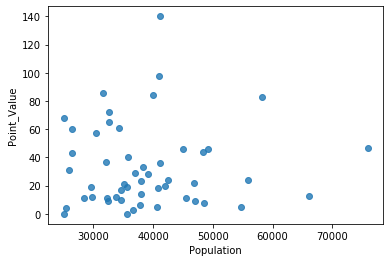

In [25]:
# use the function regplot to make a scatterplot
sns.regplot(x=toronto_df["Population"], y=toronto_df["Point_Value"], fit_reg=False)

### 4.5 Normalize the population and scale the points

In [26]:
#Normalize the data
xmax = toronto_df['Population'].max().astype(int)
xmin = toronto_df['Population'].min().astype(int)


for i in range(0, len(toronto_df)):
    toronto_df["Point_Value"][i] = (1-(toronto_df['Population'][i].astype(float) - xmin)/(xmax-xmin))*toronto_df["Point_Value"][i]

#Sort the df in descending order
toronto_df = toronto_df.sort_values(by='Point_Value', ascending=False)

#Reset index
toronto_df.reset_index(drop=True, inplace=True)

toronto_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Postal_Code,Borough,Neighborhood,Latitude,Longitude,Population,Point_Value
0,M5A,Downtown Toronto,"Harbourfront (Toronto), Regent Park",43.654260,-79.360636,41078,95
1,M4K,East Toronto,"The Danforth West, Riverdale, Toronto",43.679557,-79.352188,31583,74
2,M4E,East Toronto,The Beaches,43.676357,-79.293031,25044,68
3,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,40957,67
4,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572,32640,61


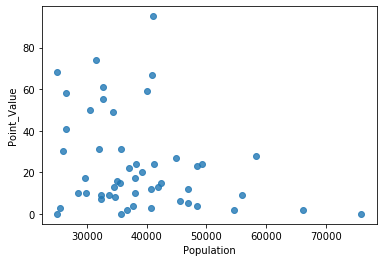

In [27]:
#use the function regplot to make a scatterplot
sns.regplot(x=toronto_df["Population"], y=toronto_df["Point_Value"], fit_reg=False)

# 5. Determine and map best locations

### 5.1 Show top three locations and attributes

In [28]:
for i in range (0, 3):
    print("[" + str(i+1) + "]")
    print("Postal Code: " + str(toronto_df['Postal_Code'][i]))
    print("Borough: " + str(toronto_df['Borough'][i]))
    print("Neighborhood: " + str(toronto_df['Neighborhood'][i]))
    print("Latitude: " + str(toronto_df['Latitude'][i]) + ", Longitude: " + str(toronto_df['Longitude'][i]))
    print("Population: " + str(toronto_df['Population'][i]))
    print("\n\n")
    

[1]
Postal Code: M5A
Borough: Downtown Toronto
Neighborhood: Harbourfront (Toronto), Regent Park
Latitude: 43.6542599, Longitude: -79.3606359
Population: 41078



[2]
Postal Code: M4K
Borough: East Toronto
Neighborhood: The Danforth West, Riverdale, Toronto
Latitude: 43.6795571, Longitude: -79.352188
Population: 31583



[3]
Postal Code: M4E
Borough: East Toronto
Neighborhood: The Beaches
Latitude: 43.67635739999999, Longitude: -79.2930312
Population: 25044





In [29]:
latitude = 43.7
longitude = -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Neighborhood'], [1,2,3]):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color='orange',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters